In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import TraceModel as tm

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-029 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-031
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


# Create the First Pass Order 1 Trace Profile 
### With help from an F277W exposure

This notebook will walk the user through the creation of a interpolated model order 1 trace profile for NIRISS SOSS observations. This first part assumes that an observation with the F277W filter was included in the program. If none were observed, skip to the second part of this notebook.

## Determine Interpolation Model Coefficients

First we 'derive' the coefficients necessary to create the interpolated trace model. The end user should never have to redo this step (hopefully) when creating a trace model from an observation.

Note that running the code in this section, as well as the 'Validate Interpolation Polynomials' section necessitates the creation and storage of a large number (~2Gb worth) of monochromatic PSF files by WebbPSF. This also takes a rather long time. If you don't want to play around with validating the interpolation polynomials, you can simply skip ahead to the 'Make the Model' section. No WebbPSF files need to be generated in order to actually make the trace model.

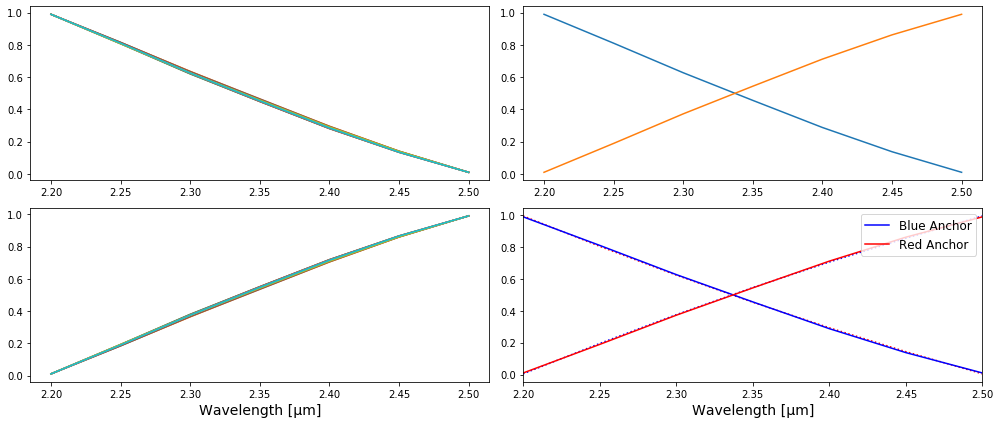

In [2]:
# Derive the normalized interpolation coefficients.
# p1 and p2 represent the polynomial coefficients for the interplation coefficient fits.
# When p1 and p2 are evaluated at some wavelength w - the monochromatic PSF profile at w
# can be constructed using p1(w) x blue anchor and p2(w) x red anchor.
p1, p2, nw1, nw2 = tm.derive_model(filepath='Monochrom_PSFs/')

### Validate the Interpolation Polynomials

In [3]:
# Read in all PSF files
waves = np.linspace(2.2, 2.5, 7)
PSFs = []
for i in range(10):
    psf_run = []
    for w in waves:
        try:
            psf_run.append(fits.open('Monochrom_PSFs/SOSS_os10_128x128_{0:.6f}_{1:.0f}.fits'
                                     .format(w, i))[0].data)
        except FileNotFoundError:
            print('bears', w, i)
            tm.loicpsf(wavelist=[w*1e-6], wfe_real=i)
            psf_run.append(fits.open('SOSS_os10_128x128_{0:.6f}_{1:.0f}.fits'
                                     .format(w, i))[0].data)
    PSFs.append(psf_run)

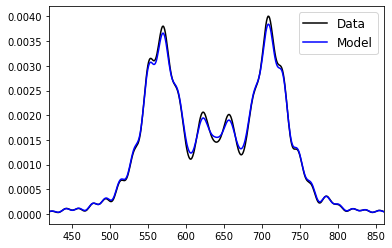

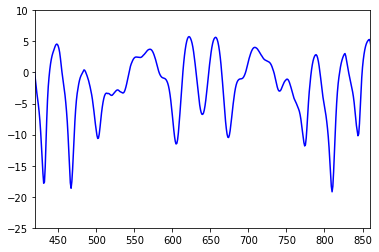

In [4]:
# Plot the results of the new interpolated model
#######
E = 5  # WFE realization index [0,9]
W = 3  # Wavelength index [0,6]
#######

wave = 2.2 + 0.05 * W

rnge2 = np.linspace(0, round(1280*(2.5/2.2), 0) - 1, 1280)
offset2 = rnge2[640] - 640
new2 = np.interp(np.arange(1280), rnge2 - offset2,
                 np.sum(PSFs[E][0][600:700, :], axis=0))

rngem = np.linspace(0, round(1280*(2.5/wave), 0) - 1, 1280)
offsetm = rngem[640] - 640

w1i = np.polyval(p1, wave)
w2i = np.polyval(p2, wave)
mixint = (w1i*new2 + w2i*np.sum(PSFs[E][6][600:700, :], axis=0))
newmint = np.interp(rngem-offsetm, np.arange(1280), mixint)

plt.plot(np.arange(1280), np.sum(PSFs[E][W][600:700, :], axis=0),
         c='black', label='Data')
plt.plot(np.arange(1280), newmint, c='blue', label='Model')
plt.xlim(420, 860)
plt.legend(fontsize=12)
plt.show()

plt.plot(np.arange(1280), 100*(np.sum(PSFs[E][W][600:700, :], axis=0) - newmint) / np.sum(PSFs[E][W][600:700, :], axis=0),c='blue')
plt.xlim(420, 860)
plt.ylim(-25, 10)
plt.show()

In [5]:
# Calculate residuals for each W and E
intmeans, means = [], []
for E in range(10):
    rnge2 = np.linspace(0, round(1280*(2.5/2.2), 0) - 1, 1280)
    offset2 = rnge2[640] - 640
    new2 = np.interp(np.arange(1280), rnge2 - offset2,
                     np.sum(PSFs[E][0][600:700, :], axis=0))

    for W in range(7):
        w11, w22 = nw1[E][W], nw2[E][W]
        wave = 2.2 + 0.05*W

        mix = (w11*new2 + w22*np.sum(PSFs[E][6][600:700, :], axis=0))

        rngem = np.linspace(0, round(1280*(2.5/wave), 0) - 1, 1280)
        offsetm = rngem[640] - 640
        newm = np.interp(rngem-offsetm, np.arange(1280), mix)

        w1i = np.polyval(p1, wave)
        w2i = np.polyval(p2, wave)
        mixint = (w1i*new2 + w2i*np.sum(PSFs[E][6][600:700, :], axis=0))
        newmint = np.interp(rngem-offsetm, np.arange(1280), mixint)

        intmeans.append(np.mean(100*np.abs((np.sum(PSFs[E][W][600:700, :], axis=0)[400:900] - newmint[400:900])) / np.abs(np.sum(PSFs[E][W][600:700, :], axis=0)[400:900])))
        means.append(np.mean(100*np.abs(np.sum(PSFs[E][W][600:700, :], axis=0)[400:900] - newm[400:900]) / np.abs(np.sum(PSFs[E][W][600:700, :], axis=0)[400:900])))

EMI = np.reshape(intmeans, (10, 7))
EM = np.reshape(means, (10, 7))

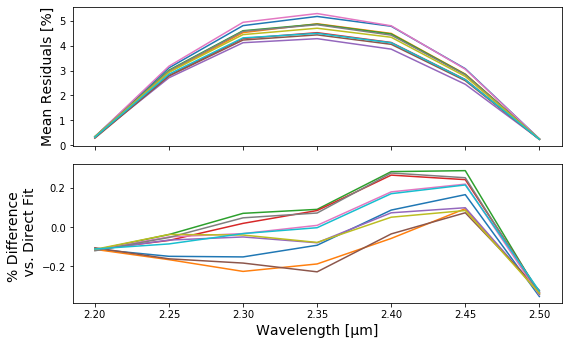

In [6]:
# Plot result
waves = np.linspace(2.2, 2.5, 7)
cmap = plt.get_cmap("tab10")

f, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
for i in range(10):
    ax[1].plot(waves, EMI[i] - EM[i], c=cmap(i))  # compare mean res of model and direct fit
    ax[0].plot(waves, EMI[i], c=cmap(i))  # mean residual for model

ax[1].set_ylabel('% Difference \n vs. Direct Fit', fontsize=14)
ax[0].set_ylabel('Mean Residuals [%]', fontsize=14)
ax[-1].set_xlabel('Wavelength [µm]', fontsize=14)
f.tight_layout()

## Make the Model

This is the only section that really needs to be completed to create a model trace profile. All that is necessary is a CLEAR and F277W exposure data frame.

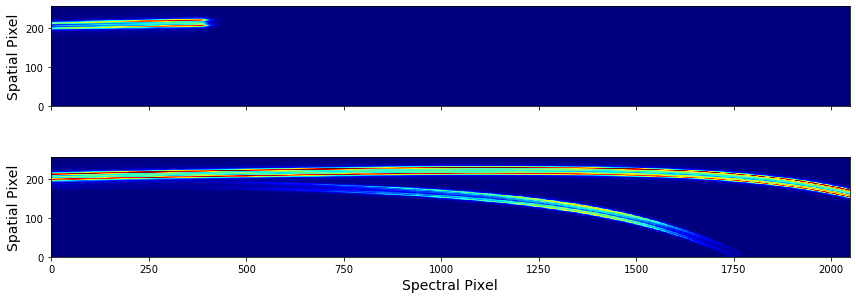

In [4]:
# Open simulated clear and F277W exposures
clear = fits.open('/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/simu_F277_CLEAR/clear.fits')[0].data[::-1, :]
F277 = fits.open('/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/simu_F277_CLEAR/f277.fits')[0].data[::-1, :]

# Visualize the frames
f, ax = plt.subplots(2, sharex=True, figsize=(12, 5))
ax[0].imshow(F277/np.nanmax(F277), origin='lower', cmap='jet')
ax[0].set_ylabel('Spatial Pixel', fontsize=14)

ax[1].imshow(clear/np.nanmax(clear, axis=0), origin='lower', cmap='jet')
ax[1].set_xlabel('Spectral Pixel', fontsize=14)
ax[1].set_ylabel('Spatial Pixel', fontsize=14)

f.tight_layout()

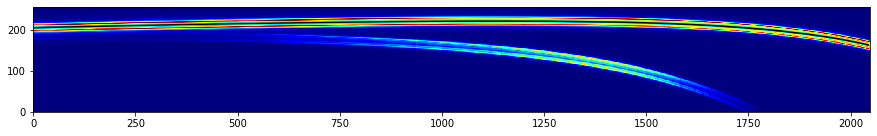

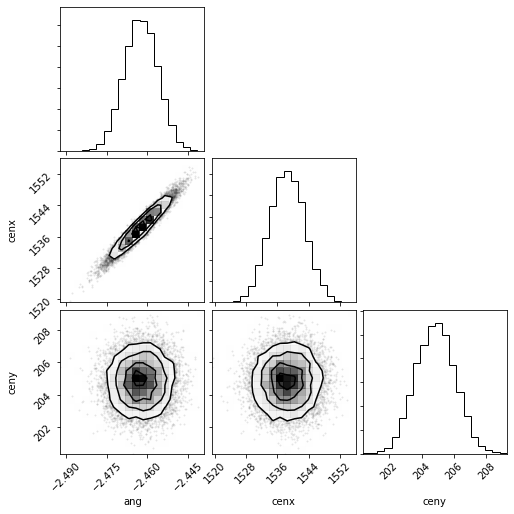

In [8]:
# The end user would really only need to call this one function which
# then completely creates the trace model for them.
# The above examples were just to demonstrate further how the code actually works.
# The trace model can also be written to disk by passing a file name with the 'filename' argument.
tracemodel_wf277 = tm.makemod(clear, F277, do_plots=True)#, filename='test')

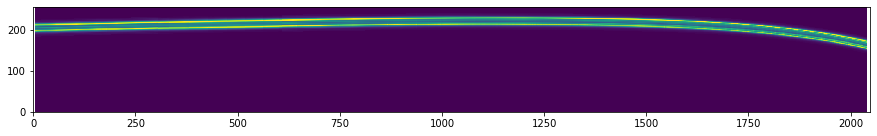

In [9]:
# Visualize the new model.
plt.figure(figsize=(15, 3))
plt.imshow(tracemodel_wf277, origin='lower')

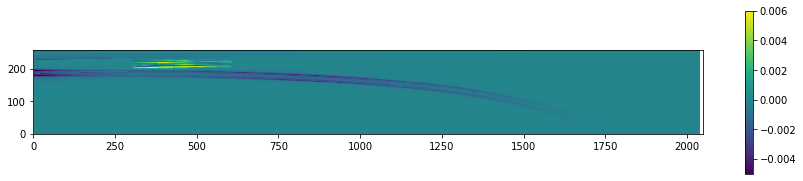

In [10]:
# Compare the model to the simulated CLEAR exposure.
# The errors are shown as a percentage of the total flux in the detector column.
plt.figure(figsize=(15, 3))
plt.imshow(100*(tracemodel_wf277 - clear/np.nanmax(clear, axis=0)) / np.sum(clear, axis=0),
           origin='lower', vmin=-0.005, vmax=0.006)
plt.colorbar()

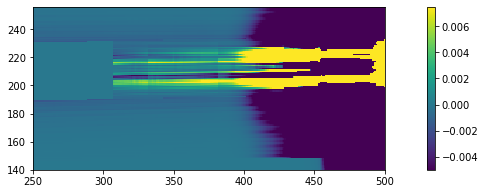

In [11]:
# Compare the model to the F277W exposure.
# This is likley the best gauge of accuracy as we know there is no contamination
# from the second order.
plt.figure(figsize=(15, 3))
plt.imshow(100*(tracemodel_wf277 - F277/np.nanmax(F277, axis=0)) / np.sum(F277, axis=0),
           origin='lower', vmin=-0.005, vmax=0.0075)
plt.ylim(140, 256)
plt.xlim(250, 500)
plt.colorbar()

# Oh No! No F277W Exposure

There is also the ability to create an interpolated trace model if there is no F277W filter exposure available. The results are however more inaccurate.

## Derive the Interpolation Polynomials and Validate them.

Note once again that this section necessitates the creation of a large number of WebbPSF monochromatic PSF files. Feel free to skip ahead if you do not want to do this.

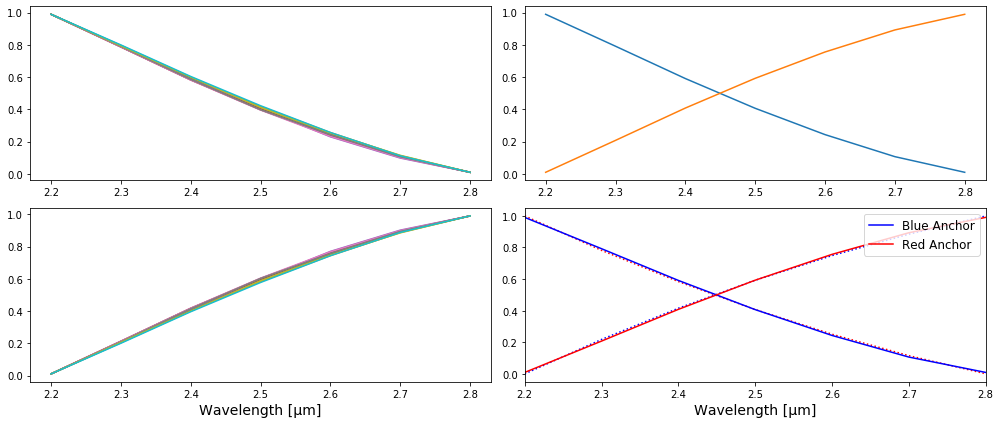

In [12]:
# Again, derive the interpolation polynomials, this time extending from 2.2 - 2.8µm.
p1, p2, nw1, nw2 = tm.derive_model(F277W=False, filepath='Monochrom_PSFs/')

In [13]:
# Read in all PSF files
waves = np.linspace(2.2, 2.8, 7)
PSFs = []
for i in range(10):
    psf_run = []
    for w in waves:
        try:
            psf_run.append(fits.open('Monochrom_PSFs/SOSS_os10_128x128_{0:.6f}_{1:.0f}.fits'
                                     .format(w, i))[0].data)
        except FileNotFoundError:
            print('bears', w, i)
            tm.loicpsf(wavelist=[w*1e-6], wfe_real=i)
            psf_run.append(fits.open('SOSS_os10_128x128_{0:.6f}_{1:.0f}.fits'
                                     .format(w, i))[0].data)
    PSFs.append(psf_run)

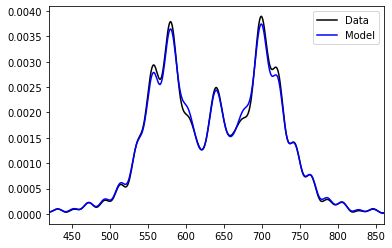

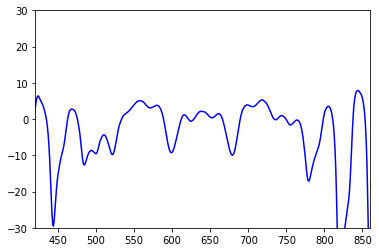

In [14]:
# Plot the results of the new model.
#####
E = 8  # WFE realization index [0, 9]
W = 5  # Wavelength index [0, 6]
#####

wave = 2.2 + 0.1*W

rnge2 = np.linspace(0, round(1280*(2.5/2.2), 0) - 1, 1280)
offset2 = rnge2[640] - 640
new2 = np.interp(np.arange(1280), rnge2 - offset2,
                 np.sum(PSFs[E][0][600:700, :], axis=0))

rnge8 = np.linspace(0, round(1280*(2.5/2.8), 0) - 1, 1280)
offset8 = rnge8[640] - 640
new8 = np.interp(np.arange(1280), rnge8 - offset8,
                 np.sum(PSFs[E][6][600:700, :], axis=0))

rngem = np.linspace(0, round(1280*(2.5/wave), 0) - 1, 1280)
offsetm = rngem[640] - 640

w1i = np.polyval(p1, wave)
w2i = np.polyval(p2, wave)
mixint = (w1i*new2 + w2i*new8)
newmint = np.interp(rngem-offsetm, np.arange(1280), mixint)

plt.plot(np.arange(1280), np.sum(PSFs[E][W][600:700, :], axis=0),
         c='black', label='Data')
plt.plot(np.arange(1280), newmint, c='blue', label='Model')
plt.xlim(420, 860)
plt.legend()
plt.show()

plt.plot(np.arange(1280), 100*(np.sum(PSFs[E][W][600:700, :], axis=0) - newmint) / np.sum(PSFs[E][W][600:700, :], axis=0),
         c='blue')
plt.xlim(420, 860)
plt.ylim(-30, 30)
plt.show()

In [15]:
# Calculate residuals for each W and E.
intmeans = []
for E in range(10):
    rnge2 = np.linspace(0, round(1280*(2.5/2.2), 0) - 1, 1280)
    offset2 = rnge2[640] - 640
    new2 = np.interp(np.arange(1280), rnge2 - offset2,
                     np.sum(PSFs[E][0][600:700, :], axis=0))

    rnge8 = np.linspace(0, round(1280*(2.5/2.8), 0) - 1, 1280)
    offset8 = rnge8[640] - 640
    new8 = np.interp(np.arange(1280), rnge8 - offset8,
                     np.sum(PSFs[9][6][600:700, :], axis=0))

    for W in range(7):
        w11, w22 = nw1[E][W], nw2[E][W]
        wave = 2.2 + 0.1*W

        rngem = np.linspace(0, round(1280*(2.5/wave), 0) - 1, 1280)
        offsetm = rngem[640] - 640

        w1i = np.polyval(p1, wave)
        w2i = np.polyval(p2, wave)
        mixint = (w1i*new2 + w2i*new8)
        newmint = np.interp(rngem-offsetm, np.arange(1280), mixint)

        intmeans.append(np.mean(100*np.abs((np.sum(PSFs[E][W][600:700, :], axis=0)[400:900] - newmint[400:900])) / np.abs(np.sum(PSFs[E][W][600:700, :], axis=0)[400:900])))

EMII = np.reshape(intmeans, (10, 7))

Text(0.5, 0, 'Wavelength [µm]')

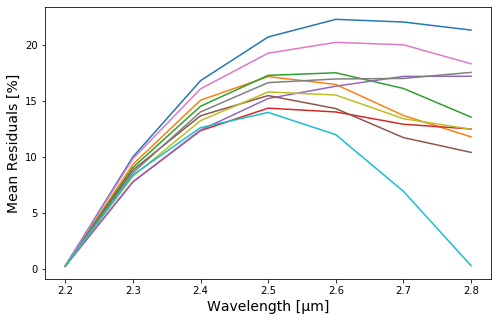

In [16]:
# Plot results.
cmap = plt.get_cmap("tab10")
plt.figure(figsize=(8, 5))
for i in range(10):
    plt.plot(waves, EMII[i], c=cmap(i))

plt.ylabel('Mean Residuals [%]', fontsize=14)
plt.xlabel('Wavelength [µm]', fontsize=14)

## Make the Model

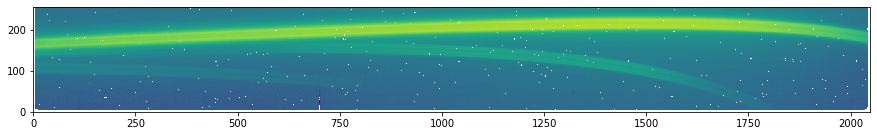

In [12]:
# Read in a 'CLEAR' exposure.
stack = fits.open('/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/Gaussian_model/InputFiles/CleanStack.fits')[0].data

plt.figure(figsize=(15, 3))
plt.imshow(np.log10(stack), origin='lower')

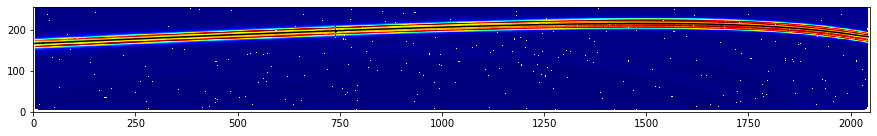

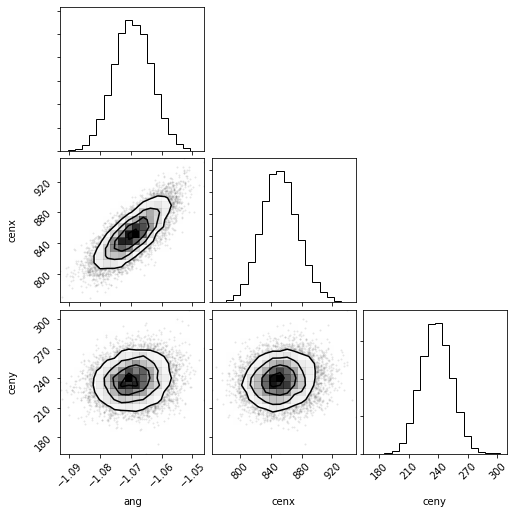

In [15]:
# Pass the CLEAR exposure and None to makemod to generate the trace model with no F277W exposure.
tracemodel_woF277 = tm.makemod(stack, None, do_plots=True)

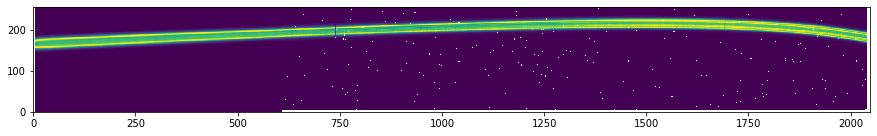

In [16]:
# Visualize the first pass model.
plt.figure(figsize=(15, 3))
plt.imshow(tracemodel_woF277, origin='lower')

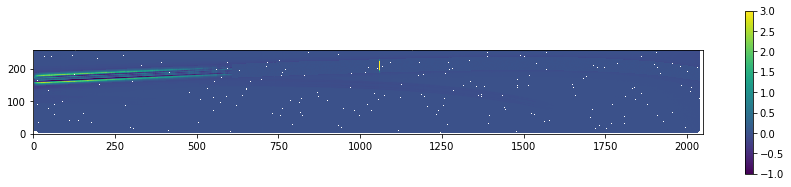

In [17]:
# Compare the model to the original CLEAR exposure.
# Again, the errors are represented as percentage of the total flux in the column.
plt.figure(figsize=(15, 3))
stack_norm = stack / np.nanmax(stack, axis=0)
plt.imshow(100*(tracemodel_woF277 - stack_norm) / np.nansum(stack_norm, axis=0),
           origin='lower', vmax=3, vmin=-1)
plt.colorbar()